# BHP share price EDA and model prediction

In [1]:
import numpy as np
import pandas as pd
import datetime
import fred
#Fred 44c14dd1fb4c61edfeb543d5b3e00562
from yahoo_fin.stock_info import get_data
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

# 1.Data collection

In [2]:
# Fred is a python library that can connect to FRED (Federal Reserve Bank of St Louise) databases via FRED API
# To use Fred, you need to obtain a key from FRED https://fred.stlouisfed.org/docs/api/fred/

fred.key('44c14dd1fb4c61edfeb543d5b3e00562')

In [3]:
# Getting the copper price from FRED
copper = fred.observations('PCOPPUSDM'.lower()) 

In [4]:
# Transform the data format from jason to series
from pandas import json_normalize
df = json_normalize(copper['observations'])
copper = df[df['value']!='.'][['date','value']]
copper['date'] = pd.to_datetime(copper['date'],format='%Y/%m/%d')
#copper['Month'] = copper['date'].apply(lambda x:x.month)
#copper['Year'] = copper['date'].apply(lambda x:x.year)

In [5]:
# apply the same method to data collection of iron ore 
ironore = fred.observations('PIORECRUSDM'.lower())
ironore = json_normalize(ironore['observations'])
ironore = ironore[ironore['value']!='.'][['date','value']]
ironore['date'] = pd.to_datetime(ironore['date'],format='%Y/%m/%d')

In [6]:
# Obtain Aus dollar/US dollar price from yahoo finance;Obtain Bhp share price price from yahoo finance
bhp = get_data("BHP.AX", start_date="01/01/2000", interval="1mo")

In [7]:
# Creating a new feature of green candle
bhp['green_candle'] = bhp['close'] < bhp['open']

In [8]:
# Getting the data of exchange rate of aud to usd
aud_usd = get_data("AUDUSD=X", start_date="01/01/2000", interval="1mo")

In [9]:
bhp.index = bhp.index.strftime('%Y-%m')

In [10]:
#check if there are any duplicate values
aud_usd.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [11]:
aud_usd.index = aud_usd.index.strftime('%Y-%m')

In [12]:
aud_usd.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,

In [13]:
aud_usd = aud_usd.groupby(aud_usd.index).mean()

/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/3345829542.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aud_usd = aud_usd.groupby(aud_usd.index).mean()


In [14]:
bhp

,open,high,low,close,adjclose,volume,ticker,green_candle
1999-12,8.317775,9.153254,7.685240,7.795445,3.100677,175817747,BHP.AX,True
2000-01,7.827466,7.943078,6.587348,6.692147,2.661833,207517907,BHP.AX,True
2000-02,6.691315,7.772572,6.487540,7.419916,2.951308,243243412,BHP.AX,False
2000-03,7.464830,7.901491,7.000305,7.668605,3.050225,123009177,BHP.AX,False
2000-04,7.568797,7.902323,6.820234,7.406608,2.946015,152583611,BHP.AX,True
...,...,...,...,...,...,...,...,...
2022-11,46.200001,47.720001,45.099998,45.630001,44.767792,173368180,BHP.AX,True
2022-12,45.630001,50.209999,44.930000,49.380001,48.446934,153546830,BHP.AX,False
2023-01,49.980000,50.044998,44.330002,45.200001,44.345917,174439304,BHP.AX,True
2023-02,45.340000,48.700001,44.910000,45.009998,44.159508,74203913,BHP.AX,True


In [15]:
#Join the dataframe first for later merging
bhp['aud_to_usd'] = aud_usd['close']

# 2. Data preprocessing

## 2.1 merging data frames

In [16]:
# Create a new data frame by joining iron ore and copper data frames
df = ironore.merge(copper, on='date')

In [17]:
# Extract date feature from bhp data frame index
bhp['date'] = bhp.index

In [18]:
# Transform the date such that BHP date format is the same as the date format of copper and iron date format
# The final date format is String
df['date'] = df['date'].dt.strftime('%Y-%m')

In [19]:
#joining bhp dataframe and copper/ironore data frame, name the merged dataframe as "df"
df = df.merge(bhp[['close','aud_to_usd','date','green_candle']], on='date')

In [20]:
# rename the features
df.columns = ['date', 'ironore', 'copper','bhp_price','aud_to_usd','green_candle']

In [21]:
# calculate iron ore price in AUD
df['ironore'] = df['ironore'].astype(float)
df['copper'] = df['copper'].astype(float)
df['ironore_aud_price'] = df['ironore']/df['aud_to_usd']
df['copper_aud_price'] = df['copper']/df['aud_to_usd']

In [22]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m')

## 2.2 Dealing with missing values

In [23]:
df[df.date>='2006-05'].isnull().sum()

date                  0
ironore               0
copper                0
bhp_price             0
aud_to_usd           17
green_candle          0
ironore_aud_price    17
copper_aud_price     17
dtype: int64

In [24]:
# delete the empty data, and rename the new data frame as "df_delete"
df_delete = df.dropna()
#use pearson correlation as feature importance , and see which feature is most important
#normally a value less than 0.2 is considered not correlated
from scipy.stats import pearsonr

print(pearsonr(df_delete['copper'], df_delete['bhp_price']))
print(pearsonr(df_delete['ironore'], df_delete['bhp_price']))
print(pearsonr(df_delete['ironore_aud_price'], df_delete['bhp_price']))
print(pearsonr(df_delete['copper_aud_price'], df_delete['bhp_price']))

PearsonRResult(statistic=0.6708650868020244, pvalue=2.0442312294155361e-25)
PearsonRResult(statistic=0.6201007892920024, pvalue=6.21289714793638e-21)
PearsonRResult(statistic=0.6713179553948956, pvalue=1.8473044039189409e-25)
PearsonRResult(statistic=0.6310222234244764, pvalue=7.918328031110036e-22)


In [25]:
# in stead of deleting, we replace each feature's empty values with population median

#df['aud_to_usd'] =df['aud_to_usd'].replace(np.nan,df['aud_to_usd'].median())
#df['bhp_price'] =df['bhp_price'].replace(np.nan,df['bhp_price'].median())
#df['ironore_aud_price'] =df['ironore_aud_price'].replace(np.nan,df['ironore_aud_price'].median())
#df['copper_aud_price'] =df['copper_aud_price'].replace(np.nan,df['copper_aud_price'].median())

In [26]:
df = df.dropna()

<Axes: xlabel='ironore_aud_price', ylabel='Count'>

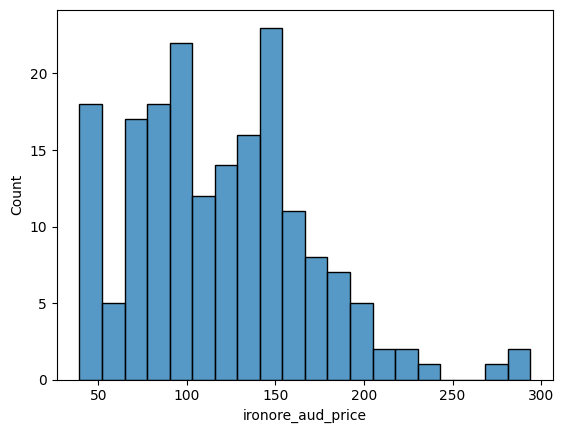

In [27]:
# Histogram of iron ore price before any scaling 

sns.histplot(data=df, x="ironore_aud_price",bins=20)

## 2.3 Scaling the data

In [28]:
# Histogram of iron ore price after normalisation 

x_array = np.array(df['ironore_aud_price'])
normalized_arr = preprocessing.normalize([x_array])
df['normalized_iron_aud']=normalized_arr[0]


x_array = np.array(df['copper_aud_price'])
normalized_arr = preprocessing.normalize([x_array])
df['normalized_copper_aud']=normalized_arr[0]

<Axes: xlabel='normalized_iron_aud', ylabel='Count'>

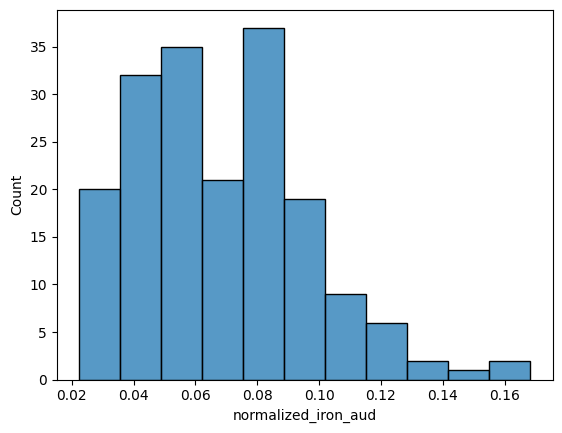

In [29]:
sns.histplot(data=df, x="normalized_iron_aud")

In [30]:
#Histogram of iron ore price after min max scaling 
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(df[['ironore_aud_price','copper_aud_price']])
scaled_df = pd.DataFrame(d, columns=['ironore_aud_price','copper_aud_price'])

<Axes: xlabel='ironore_aud_price', ylabel='Count'>

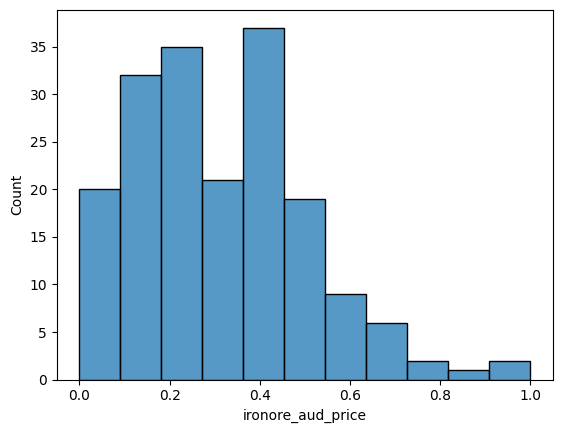

In [31]:
sns.histplot(data=scaled_df, x="ironore_aud_price")

In [32]:
df.reset_index(inplace=True)

In [33]:
df[['ironore_aud_min_max_scaled','copper_aud_min_max_scaled']] = scaled_df[['ironore_aud_price','copper_aud_price']]

## 2.4 Viewing data in terms of bins (reducing noise)

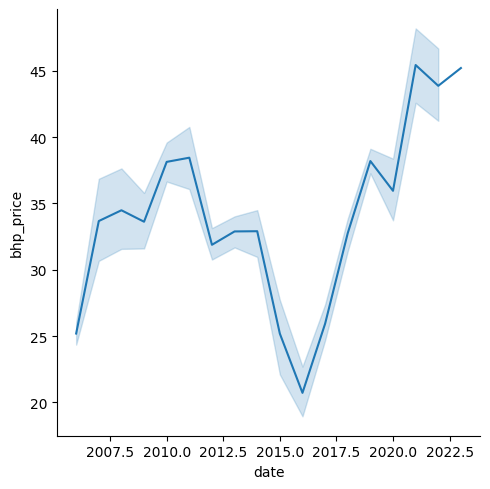

In [34]:
#bhp share price before binning
sns.relplot(x=df['date'].dt.year, y='bhp_price',  kind='line', data=df)

<Axes: xlabel='date', ylabel='bhp_price'>

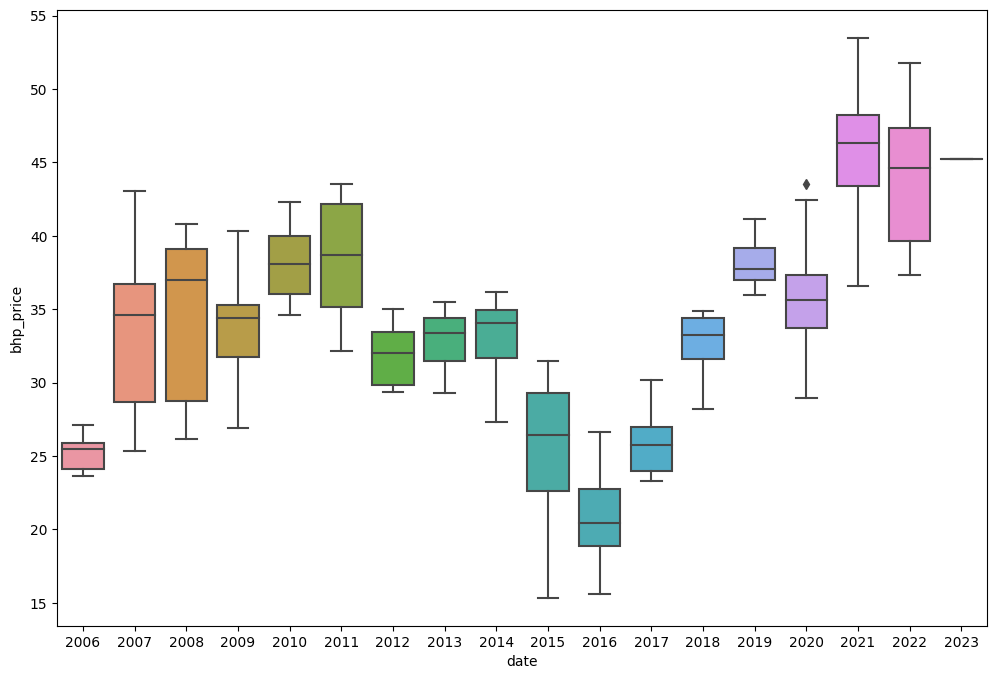

In [35]:
#bhp share price after binning
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.boxplot(x=df['date'].dt.year, y=df['bhp_price'])

## 2.5 Detecting outliers

In [36]:
# Inter Quartile Range (IQR) Outlier detection
q1 = df['bhp_price'].quantile(0.25)
q3 = df['bhp_price'].quantile(0.75)
iqr = q3 - q1
df = df[(df['bhp_price']>q1-1.5*iqr) & (df['bhp_price']<q3+1.5*iqr)]

In [38]:
#calculate Z score to detecte the outliers
from scipy import stats
df['bhp_price_zscore']= np.abs(stats.zscore(df['bhp_price']))

<Axes: xlabel='bhp_price_zscore', ylabel='Count'>

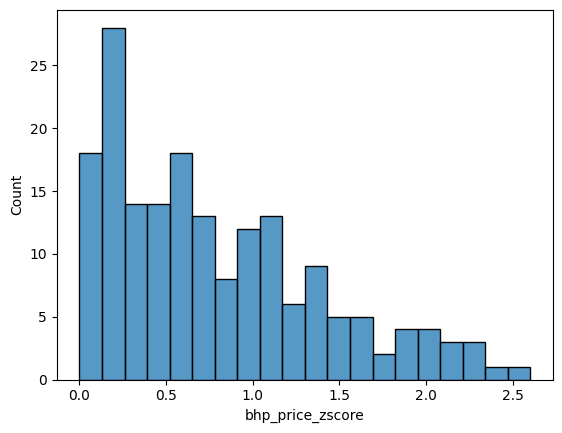

In [39]:
#most of values from histogram are below 2
sns.histplot(data=df, x="bhp_price_zscore",bins=20)

In [40]:
#Select data that have a zscore less than 3 (Usually z-score =3 is considered as a cut-off value to set the limit)
df = df[df['bhp_price_zscore']<3]

In [37]:
df.drop(columns=['index'],inplace=True)

In [38]:
df

,date,ironore,copper,bhp_price,aud_to_usd,green_candle,ironore_aud_price,copper_aud_price,normalized_iron_aud,normalized_copper_aud,ironore_aud_min_max_scaled,copper_aud_min_max_scaled
0,2006-05-01,33.450000,8059.190476,27.098803,0.742777,False,45.033734,10850.087926,0.025781,0.090982,0.022471,0.662155
1,2006-06-01,33.450000,7222.772727,25.949438,0.765873,True,43.675665,9430.774289,0.025003,0.079081,0.017138,0.516424
2,2006-07-01,33.450000,7726.738095,25.884027,0.763301,False,43.822843,10122.799225,0.025087,0.084884,0.017716,0.587479
3,2006-08-01,33.450000,7690.250000,23.949734,0.746491,True,44.809620,10301.858875,0.025652,0.086385,0.021591,0.605865
4,2006-09-01,33.450000,7622.642857,25.491562,0.775014,False,43.160535,9835.496037,0.024708,0.082474,0.015115,0.557980
...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-08-01,109.065217,7990.812174,38.520000,0.651300,False,167.457754,12269.021152,0.095865,0.102881,0.503207,0.807847
180,2022-09-01,100.840909,7746.011364,37.360001,0.640131,True,157.531662,12100.664836,0.090183,0.101469,0.464229,0.790560
181,2022-11-01,94.568182,8049.861364,45.630001,0.668409,True,141.482510,12043.317019,0.080995,0.100988,0.401207,0.784672
182,2022-12-01,111.409091,8371.091364,49.380001,0.680700,False,163.668430,12297.770011,0.093696,0.103122,0.488327,0.810798


# 3. Data visualisation

In [39]:
df_vis = df[['date','ironore_aud_price','copper_aud_price','green_candle','bhp_price']]

In [40]:
df_vis = df_vis[df_vis['date']>'2006-05']

In [41]:
df_vis['year'] = df_vis['date'].dt.year

In [42]:
df_vis_median = df_vis[['ironore_aud_price','copper_aud_price','bhp_price','year']].groupby('year').median()

In [43]:
df_vis_median['year'] = df_vis_median.index.astype(str)

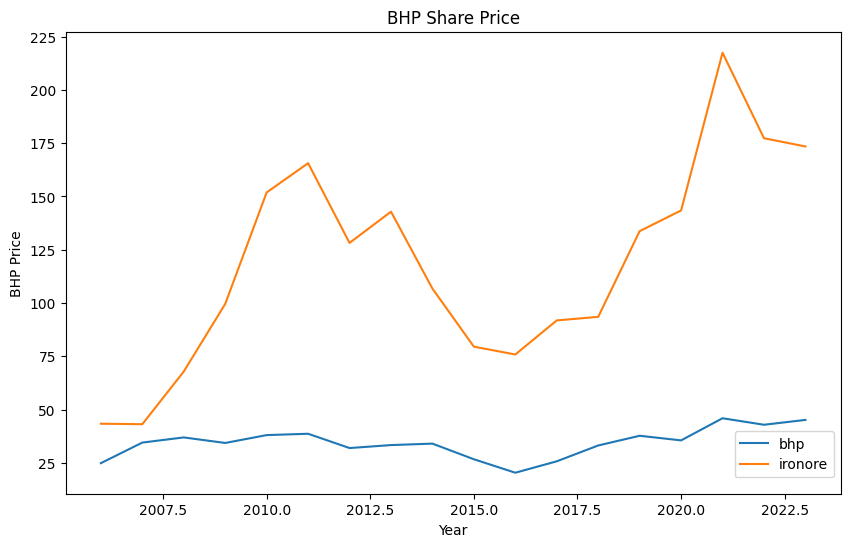

In [44]:
plt.figure(figsize=(10, 6))
plt.plot('bhp_price',data=df_vis_median,label='bhp')
plt.plot('ironore_aud_price',data=df_vis_median,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

Text(0.5, 1.0, 'BHP Share Price')

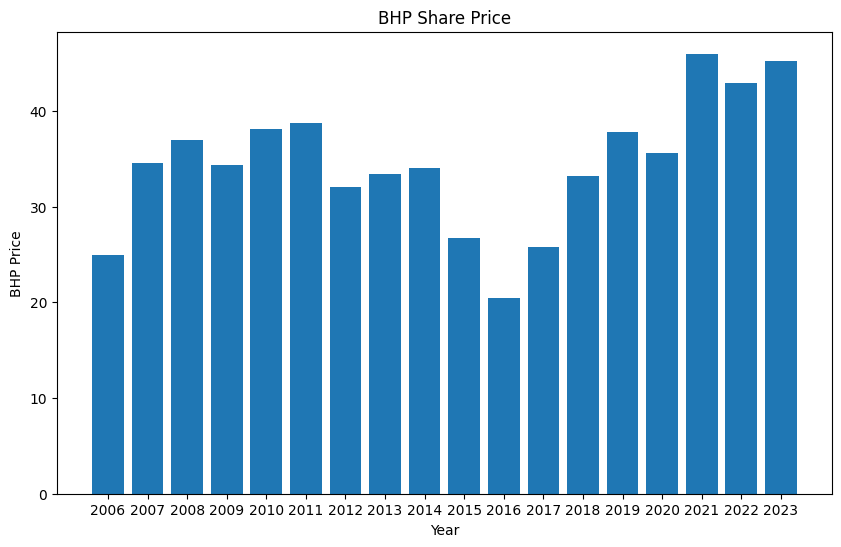

In [45]:
plt.figure(figsize=(10, 6))
plt.bar(x=df_vis_median['year'],height=df_vis_median['bhp_price'],label='bhp')
#plt.bar(x=df_vis_median['year'],height=df_vis_median['ironore_aud_price'],label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
#plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

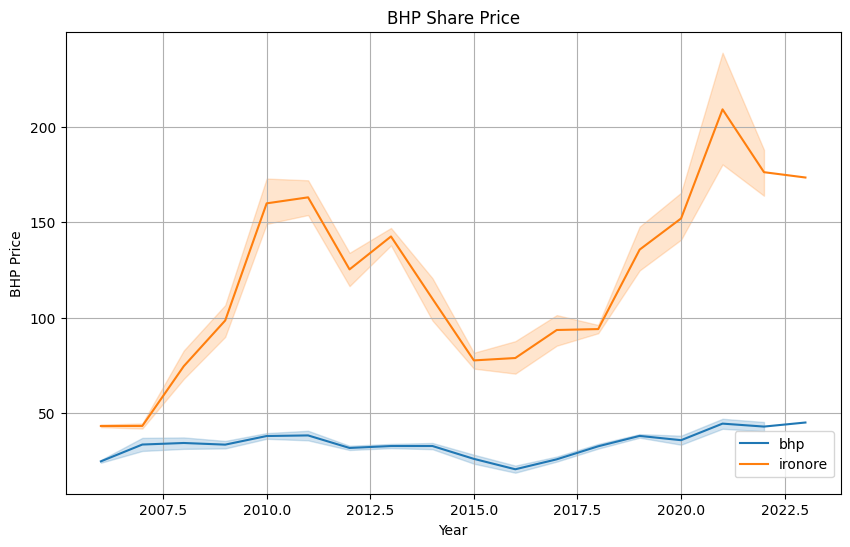

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='year',y='bhp_price',data=df_vis,label='bhp')
sns.lineplot(x='year',y='ironore_aud_price',data=df_vis,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)
plt.grid(True)

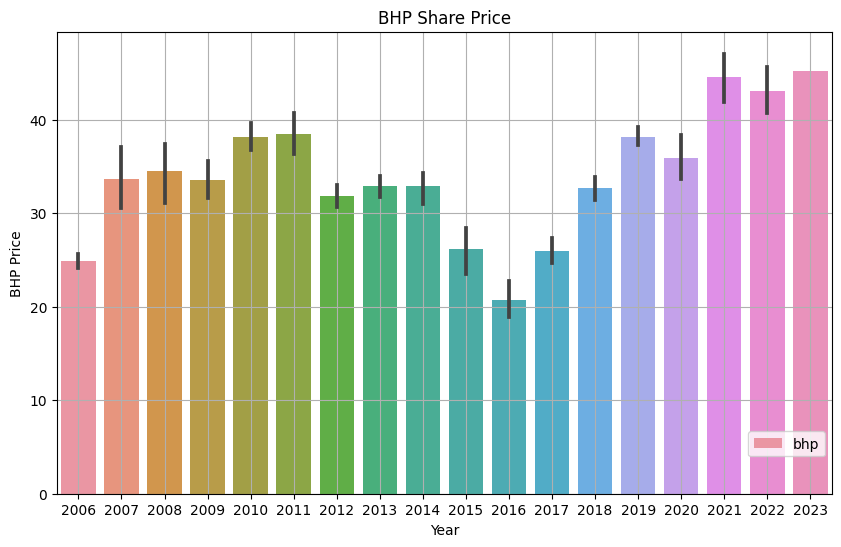

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(x='year',y='bhp_price',data=df_vis,label='bhp')
#sns.barplot(x='year',y='ironore_aud_price',data=df_vis,label='ironore')
plt.xlabel('Year')
plt.ylabel('BHP Price')
plt.title('BHP Share Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)
plt.grid(True)

<Axes: xlabel='year', ylabel='bhp_price'>

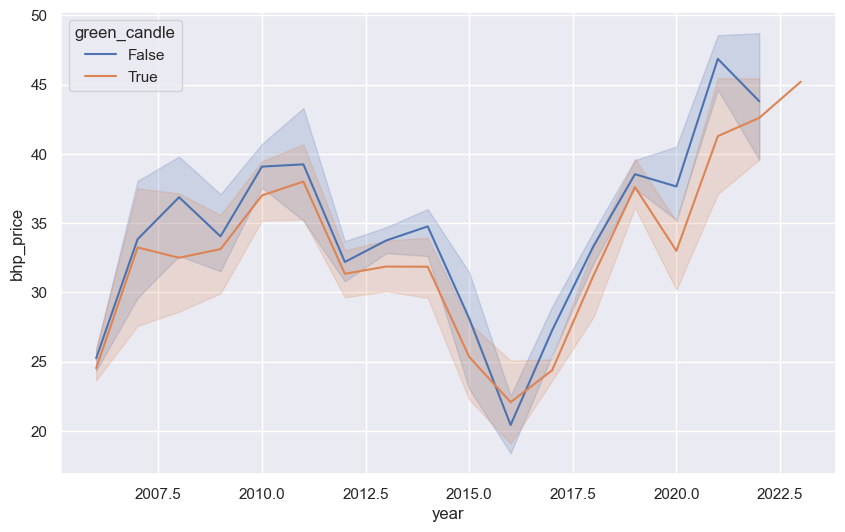

In [48]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(x='year',y='bhp_price',data=df_vis,hue='green_candle')

<Axes: xlabel='year', ylabel='bhp_price'>

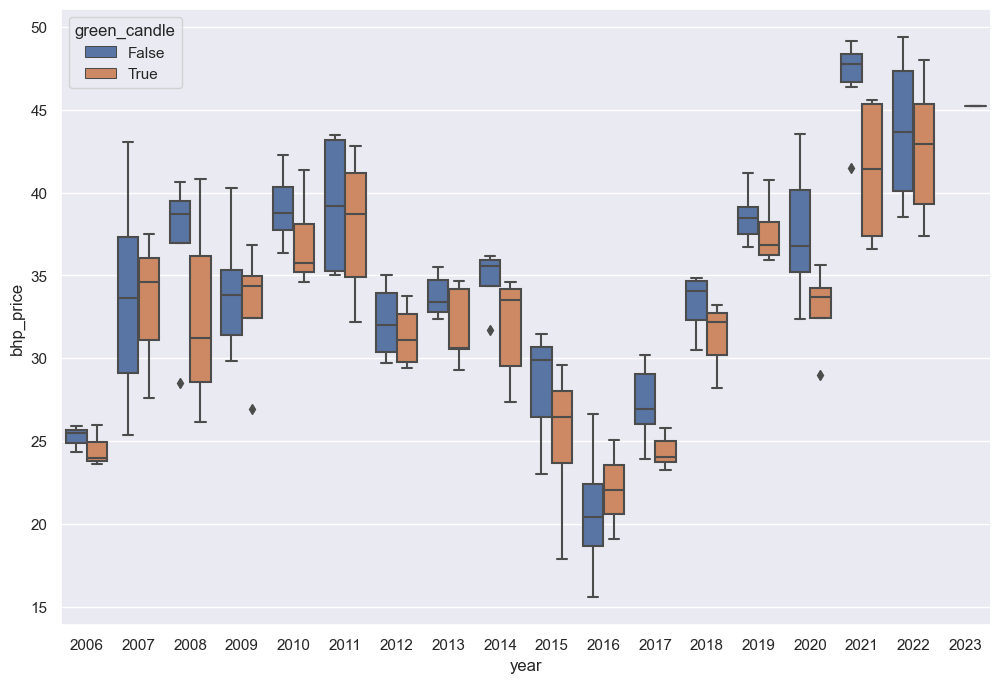

In [49]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='year',y='bhp_price',hue='green_candle',data=df_vis)

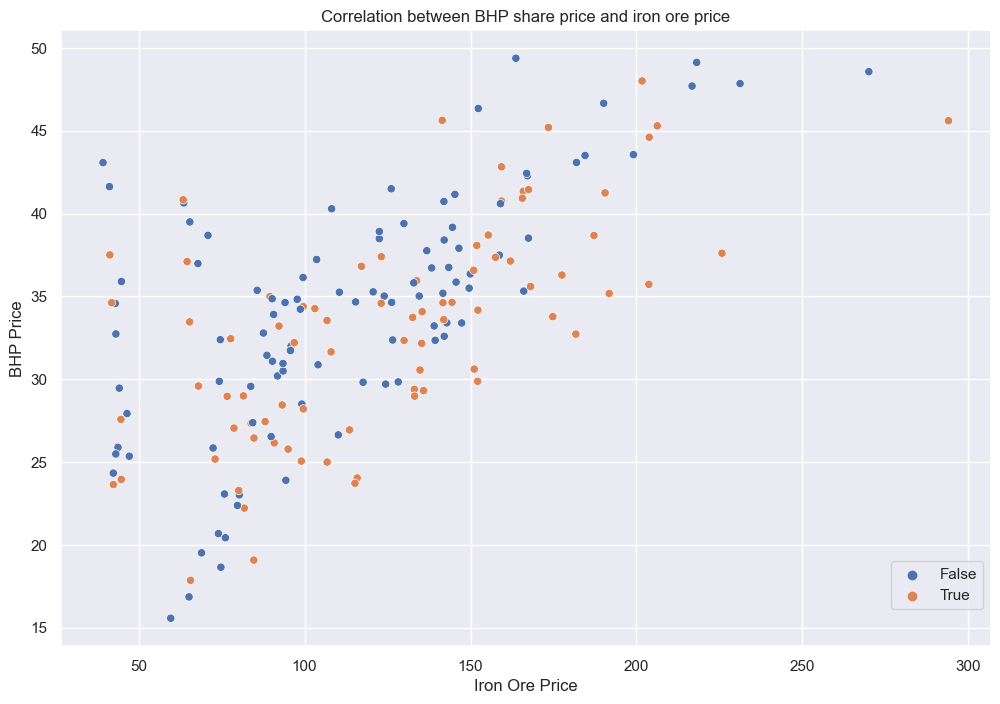

In [50]:
ax = sns.scatterplot(x='ironore_aud_price', y='bhp_price',hue='green_candle',data=df_vis)
ax.set_xlabel('Iron Ore Price')
ax.set_ylabel('BHP Price')
ax.set_title('Correlation between BHP share price and iron ore price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

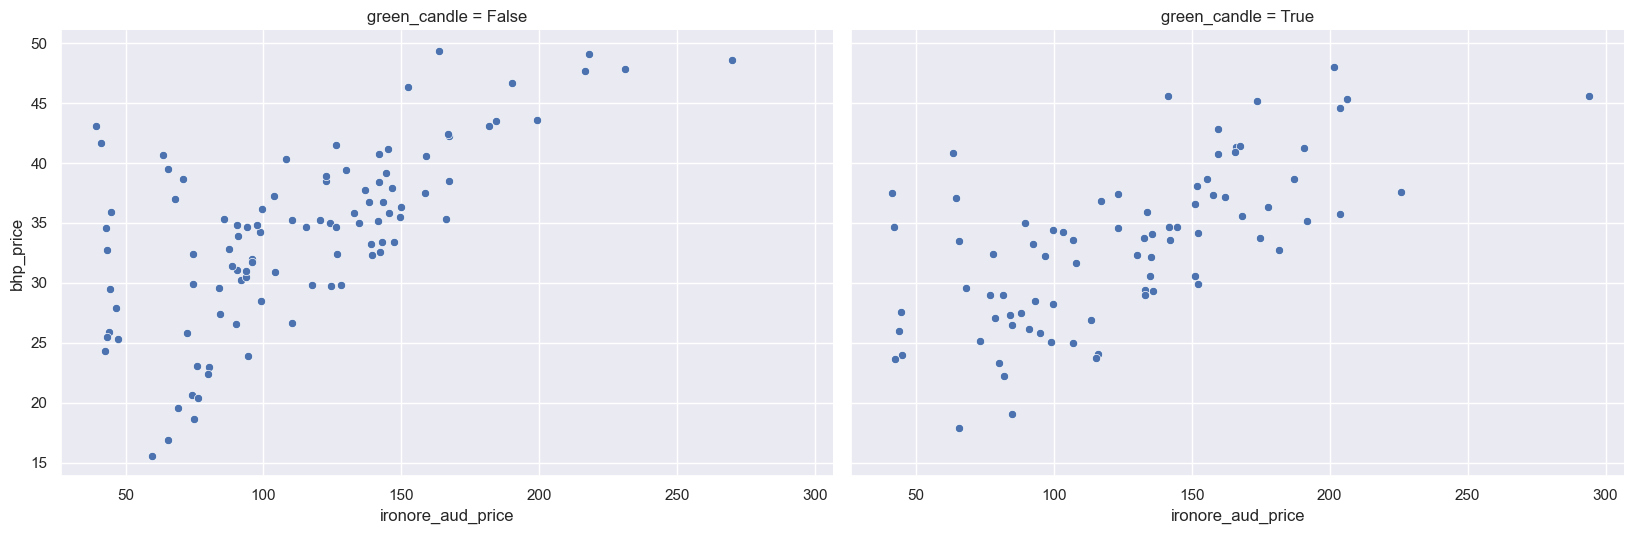

In [51]:
g = sns.FacetGrid(df_vis, col='green_candle',height=5.5, aspect=1.5)
g.map_dataframe(sns.scatterplot, x='ironore_aud_price', y='bhp_price')

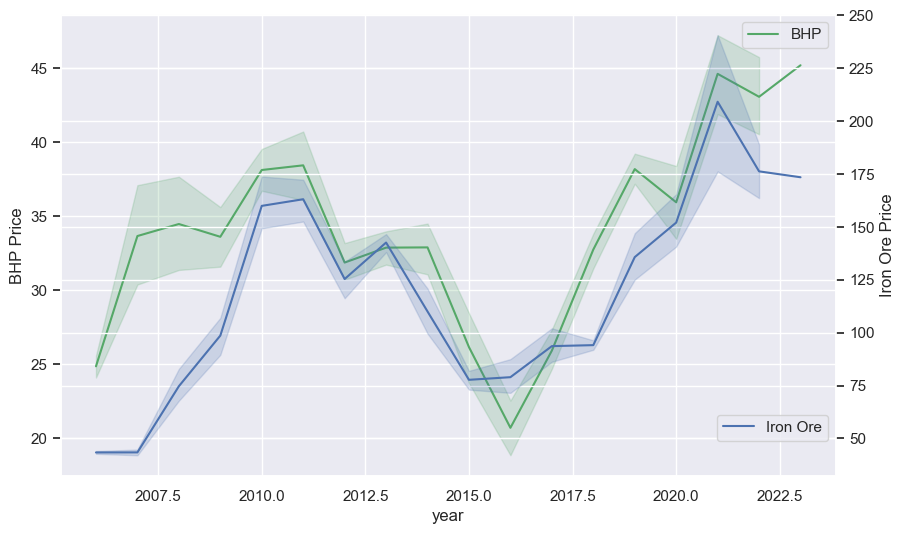

In [52]:
plt.figure(figsize=(10, 6))
ax1 = sns.lineplot(x='year', y='bhp_price', data=df_vis, color='g',label='BHP')
ax1.set_ylabel('BHP Price')
ax3 = plt.twinx()
ax2 = sns.lineplot(x='year', y='ironore_aud_price', data=df_vis, color='b',label='Iron Ore',ax=ax3)
ax2.set_ylabel('Iron Ore Price')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.15), shadow=False, ncol=1)

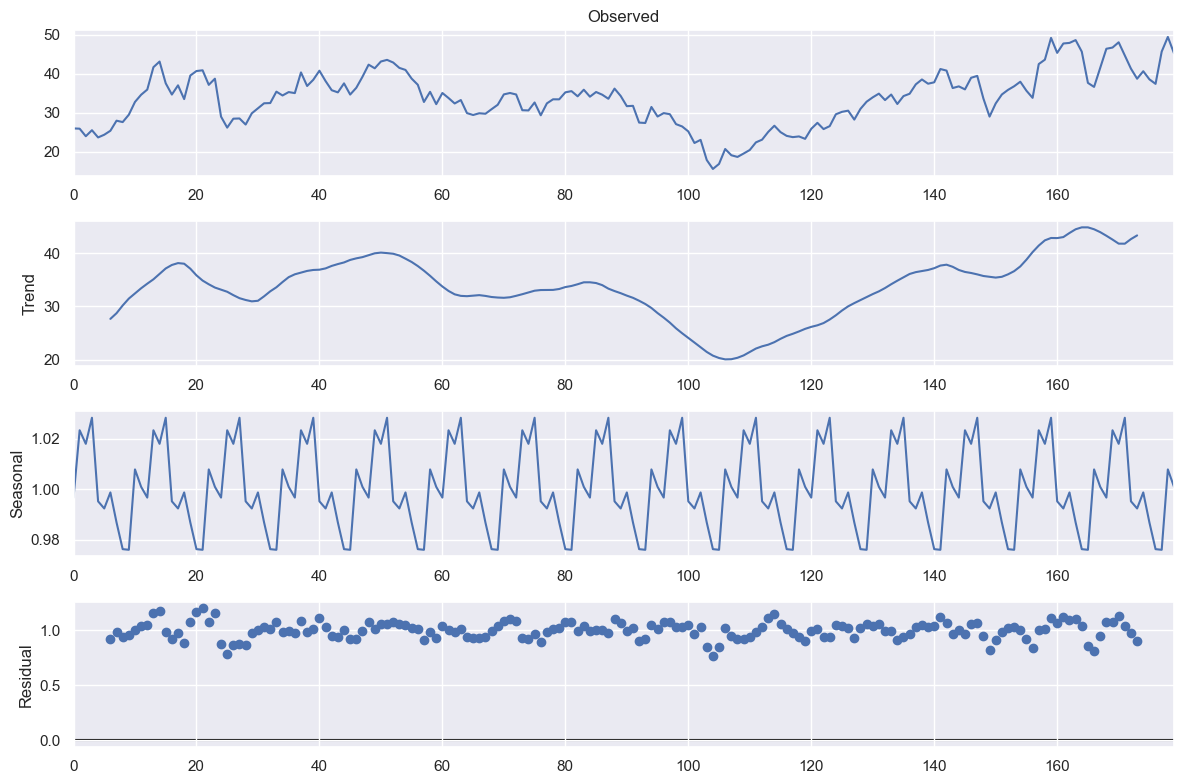

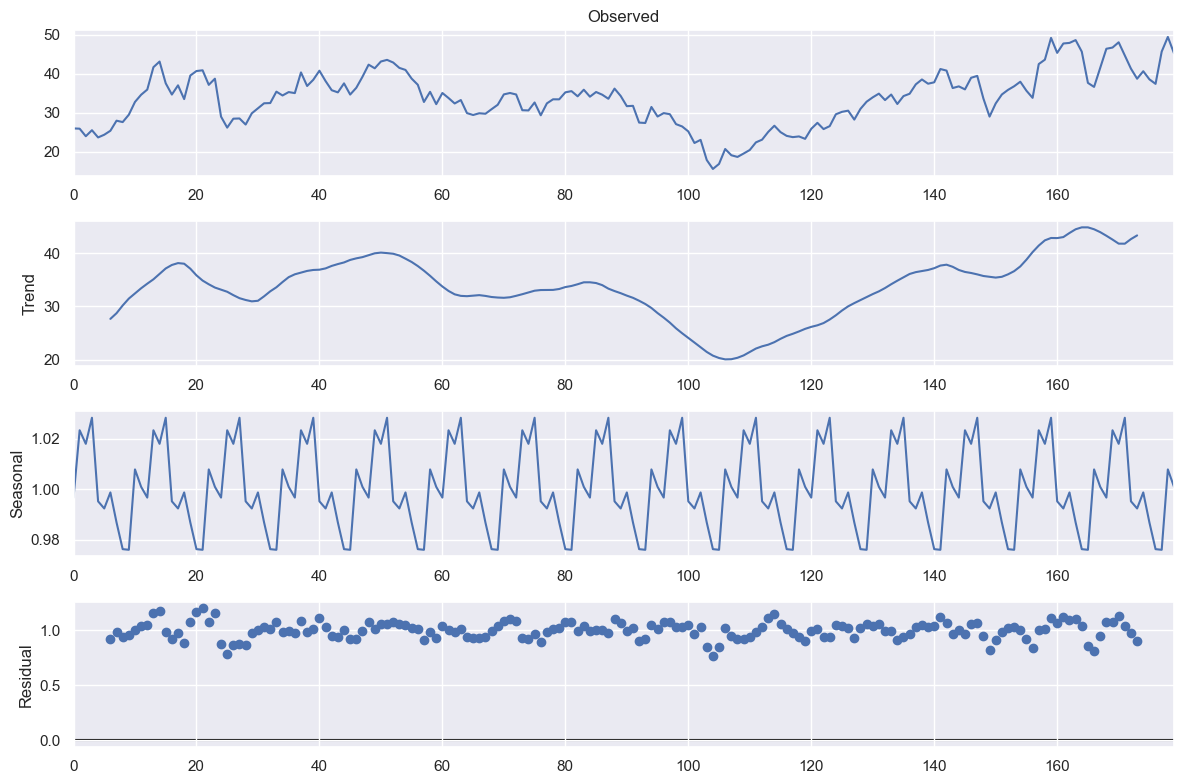

In [53]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(np.array(df_vis['bhp_price']),model='multiplicative', period=12)
res.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

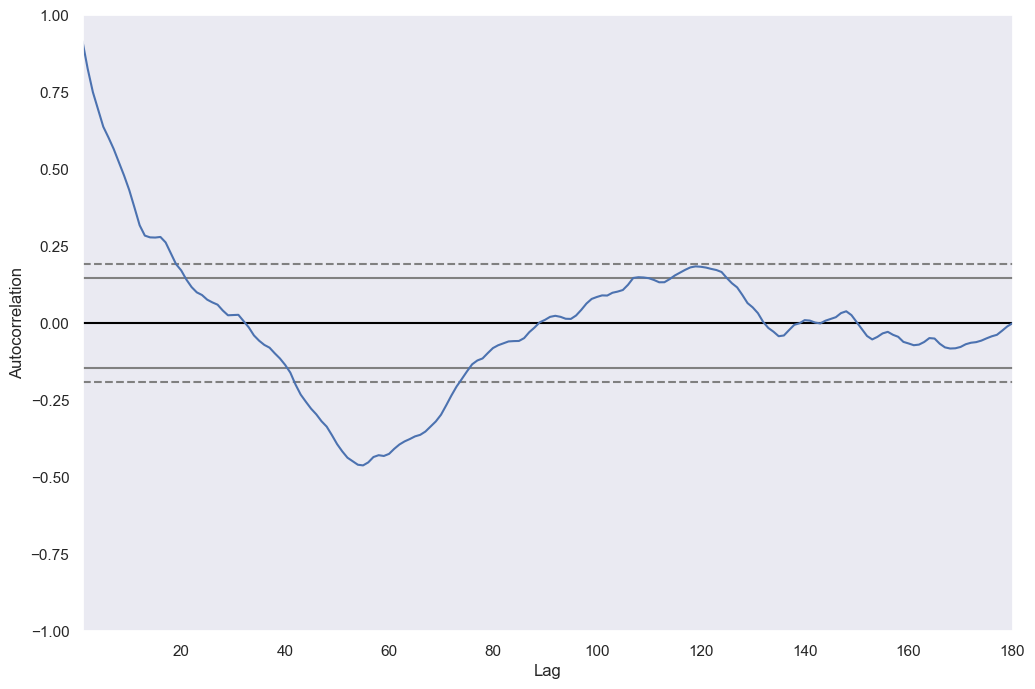

In [54]:
plt.figure(figsize=(12,8))
pd.plotting.autocorrelation_plot(df_vis['bhp_price'])

In [55]:
df_vis['bhp_price'].autocorr(lag=6)

0.6463516442756001

In [56]:
df

,date,ironore,copper,bhp_price,aud_to_usd,green_candle,ironore_aud_price,copper_aud_price,normalized_iron_aud,normalized_copper_aud,ironore_aud_min_max_scaled,copper_aud_min_max_scaled
0,2006-05-01,33.450000,8059.190476,27.098803,0.742777,False,45.033734,10850.087926,0.025781,0.090982,0.022471,0.662155
1,2006-06-01,33.450000,7222.772727,25.949438,0.765873,True,43.675665,9430.774289,0.025003,0.079081,0.017138,0.516424
2,2006-07-01,33.450000,7726.738095,25.884027,0.763301,False,43.822843,10122.799225,0.025087,0.084884,0.017716,0.587479
3,2006-08-01,33.450000,7690.250000,23.949734,0.746491,True,44.809620,10301.858875,0.025652,0.086385,0.021591,0.605865
4,2006-09-01,33.450000,7622.642857,25.491562,0.775014,False,43.160535,9835.496037,0.024708,0.082474,0.015115,0.557980
...,...,...,...,...,...,...,...,...,...,...,...,...
179,2022-08-01,109.065217,7990.812174,38.520000,0.651300,False,167.457754,12269.021152,0.095865,0.102881,0.503207,0.807847
180,2022-09-01,100.840909,7746.011364,37.360001,0.640131,True,157.531662,12100.664836,0.090183,0.101469,0.464229,0.790560
181,2022-11-01,94.568182,8049.861364,45.630001,0.668409,True,141.482510,12043.317019,0.080995,0.100988,0.401207,0.784672
182,2022-12-01,111.409091,8371.091364,49.380001,0.680700,False,163.668430,12297.770011,0.093696,0.103122,0.488327,0.810798


# 4. Data modelling

In [57]:
df_model = df[['date','ironore_aud_min_max_scaled','copper_aud_min_max_scaled','green_candle','bhp_price']]

In [58]:
df_model['green_candle'] = pd.get_dummies(df_model['green_candle'])[True]

/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/4289251085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['green_candle'] = pd.get_dummies(df_model['green_candle'])[True]


In [59]:
df_model.set_index('date',inplace=True)

In [60]:
df_model['bhp_pct'] = df_model['bhp_price'].pct_change(periods=1)

/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/2169796675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['bhp_pct'] = df_model['bhp_price'].pct_change(periods=1)


In [61]:
columns_lag = ['ironore_aud_min_max_scaled','copper_aud_min_max_scaled','bhp_price','bhp_pct','green_candle']
nums_lag = 3

In [62]:
for column in columns_lag:
    for num in np.arange(nums_lag):
        df_model['t-'+str(num+1)+'_'+str(column)] = df_model[column].shift(num+1)

/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/3536588942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['t-'+str(num+1)+'_'+str(column)] = df_model[column].shift(num+1)
/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/3536588942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['t-'+str(num+1)+'_'+str(column)] = df_model[column].shift(num+1)
/var/folders/7p/cfjb0m7n6d512djmhl4zhwrh0000gn/T/ipykernel_8244/3536588942.py:3: SettingWithCopyWarning: 
A va

In [63]:
column_predict = 'bhp_price'
nums_predict = 3

In [64]:
for num in np.arange(nums_predict):
    df_model['t+'+str(num+1)+'_'+str(column_predict)] = df_model[column_predict].shift(-num-1)

In [65]:
df_model.columns

Index(['ironore_aud_min_max_scaled', 'copper_aud_min_max_scaled',
       'green_candle', 'bhp_price', 'bhp_pct',
       't-1_ironore_aud_min_max_scaled', 't-2_ironore_aud_min_max_scaled',
       't-3_ironore_aud_min_max_scaled', 't-1_copper_aud_min_max_scaled',
       't-2_copper_aud_min_max_scaled', 't-3_copper_aud_min_max_scaled',
       't-1_bhp_price', 't-2_bhp_price', 't-3_bhp_price', 't-1_bhp_pct',
       't-2_bhp_pct', 't-3_bhp_pct', 't-1_green_candle', 't-2_green_candle',
       't-3_green_candle', 't+1_bhp_price', 't+2_bhp_price', 't+3_bhp_price'],
      dtype='object')

In [66]:
df_model_pre = df_model.dropna()

In [67]:
df_model

,ironore_aud_min_max_scaled,copper_aud_min_max_scaled,green_candle,bhp_price,bhp_pct,t-1_ironore_aud_min_max_scaled,t-2_ironore_aud_min_max_scaled,t-3_ironore_aud_min_max_scaled,t-1_copper_aud_min_max_scaled,t-2_copper_aud_min_max_scaled,...,t-3_bhp_price,t-1_bhp_pct,t-2_bhp_pct,t-3_bhp_pct,t-1_green_candle,t-2_green_candle,t-3_green_candle,t+1_bhp_price,t+2_bhp_price,t+3_bhp_price
date,,,,,,,,,,,,,,,,,,,,,
2006-05-01,0.022471,0.662155,0,27.098803,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.949438,25.884027,23.949734
2006-06-01,0.017138,0.516424,1,25.949438,-0.042414,0.022471,NaN,NaN,0.662155,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,25.884027,23.949734,25.491562
2006-07-01,0.017716,0.587479,0,25.884027,-0.002521,0.017138,0.022471,NaN,0.516424,0.662155,...,NaN,-0.042414,NaN,NaN,1.0,0.0,NaN,23.949734,25.491562,23.641369
2006-08-01,0.021591,0.605865,1,23.949734,-0.074729,0.017716,0.017138,0.022471,0.587479,0.516424,...,27.098803,-0.002521,-0.042414,NaN,0.0,1.0,0.0,25.491562,23.641369,24.332855
2006-09-01,0.015115,0.557980,0,25.491562,0.064378,0.021591,0.017716,0.017138,0.605865,0.587479,...,25.949438,-0.074729,-0.002521,-0.042414,1.0,0.0,1.0,23.641369,24.332855,25.351397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.503207,0.807847,0,38.520000,-0.051231,0.470081,0.580674,0.593793,0.677798,0.877982,...,41.250000,0.049638,-0.062303,-0.075319,0.0,1.0,1.0,37.360001,45.630001,49.380001
2022-09-01,0.464229,0.790560,1,37.360001,-0.030114,0.503207,0.470081,0.580674,0.807847,0.677798,...,38.680000,-0.051231,0.049638,-0.062303,0.0,0.0,1.0,45.630001,49.380001,45.200001
2022-11-01,0.401207,0.784672,1,45.630001,0.221360,0.464229,0.503207,0.470081,0.790560,0.807847,...,40.599998,-0.030114,-0.051231,0.049638,1.0,0.0,0.0,49.380001,45.200001,NaN


In [68]:
df_model_pre

,ironore_aud_min_max_scaled,copper_aud_min_max_scaled,green_candle,bhp_price,bhp_pct,t-1_ironore_aud_min_max_scaled,t-2_ironore_aud_min_max_scaled,t-3_ironore_aud_min_max_scaled,t-1_copper_aud_min_max_scaled,t-2_copper_aud_min_max_scaled,...,t-3_bhp_price,t-1_bhp_pct,t-2_bhp_pct,t-3_bhp_pct,t-1_green_candle,t-2_green_candle,t-3_green_candle,t+1_bhp_price,t+2_bhp_price,t+3_bhp_price
date,,,,,,,,,,,,,,,,,,,,,
2006-09-01,0.015115,0.557980,0,25.491562,0.064378,0.021591,0.017716,0.017138,0.605865,0.587479,...,25.949438,-0.074729,-0.002521,-0.042414,1.0,0.0,1.0,23.641369,24.332855,25.351397
2006-11-01,0.012199,0.463348,1,23.641369,-0.072581,0.015115,0.021591,0.017716,0.557980,0.605865,...,25.884027,0.064378,-0.074729,-0.002521,0.0,1.0,0.0,24.332855,25.351397,27.930454
2006-12-01,0.012147,0.417721,0,24.332855,0.029249,0.012199,0.015115,0.021591,0.463348,0.557980,...,23.949734,-0.072581,0.064378,-0.074729,1.0,0.0,1.0,25.351397,27.930454,27.575367
2007-01-01,0.031069,0.301206,0,25.351397,0.041859,0.012147,0.012199,0.015115,0.417721,0.463348,...,25.491562,0.029249,-0.072581,0.064378,0.0,1.0,0.0,27.930454,27.575367,29.462938
2007-02-01,0.028379,0.294040,0,27.930454,0.101732,0.031069,0.012147,0.012199,0.301206,0.417721,...,23.641369,0.041859,0.029249,-0.072581,0.0,0.0,1.0,27.575367,29.462938,32.733482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,0.593793,0.950117,1,41.250000,-0.075319,0.646072,0.637603,0.592195,1.000000,0.985944,...,46.660000,-0.070819,0.028933,0.006688,1.0,1.0,0.0,38.680000,40.599998,38.520000
2022-06-01,0.580674,0.877982,1,38.680000,-0.062303,0.593793,0.646072,0.637603,0.950117,1.000000,...,48.009998,-0.075319,-0.070819,0.028933,1.0,1.0,1.0,40.599998,38.520000,37.360001
2022-07-01,0.470081,0.677798,0,40.599998,0.049638,0.580674,0.593793,0.646072,0.877982,0.950117,...,44.610001,-0.062303,-0.075319,-0.070819,1.0,1.0,1.0,38.520000,37.360001,45.630001


In [69]:
# train test split
df_train = df_model_pre[pd.to_datetime(df_model_pre.index,format='%Y-%m').year < 2021]
df_test = df_model_pre[pd.to_datetime(df_model_pre.index,format='%Y-%m').year >= 2021]

In [70]:
from sklearn.linear_model import LinearRegression

In [71]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

5.770440707232974

<Axes: xlabel='date', ylabel='t+3_bhp_price'>

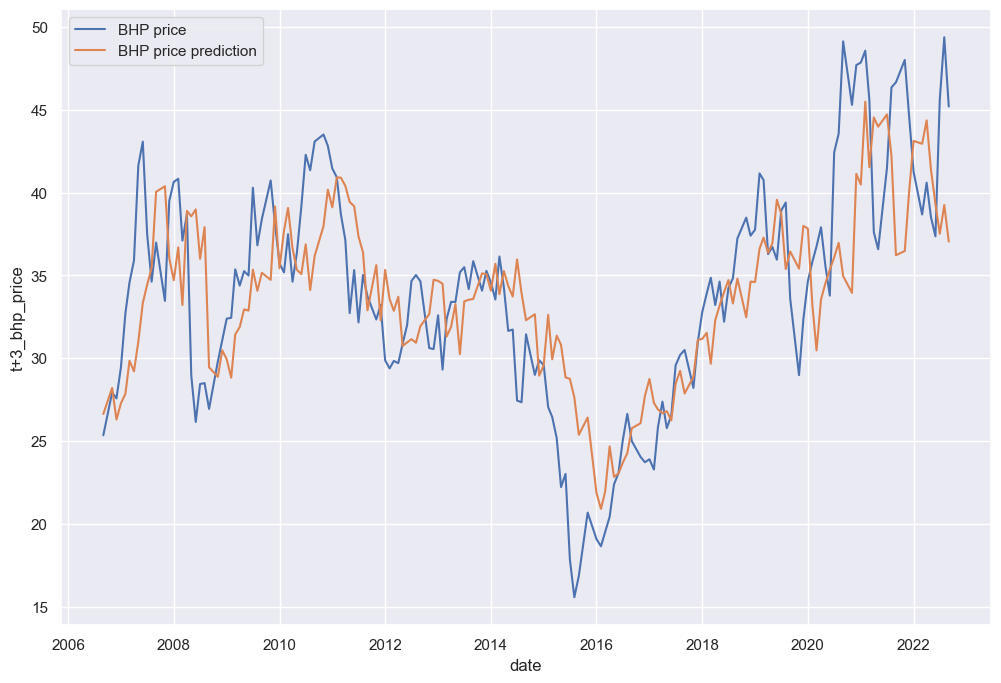

In [72]:
sns.lineplot(x=df_model_pre.index,y=df_model_pre[column_target],label='BHP price')
sns.lineplot(x=df_model_pre.index,y=bhp_model.predict(df_model_pre[columns_train]),label='BHP price prediction')

In [73]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-3_bhp_pct']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

5.658149134610917

<Axes: xlabel='date', ylabel='t+3_bhp_price'>

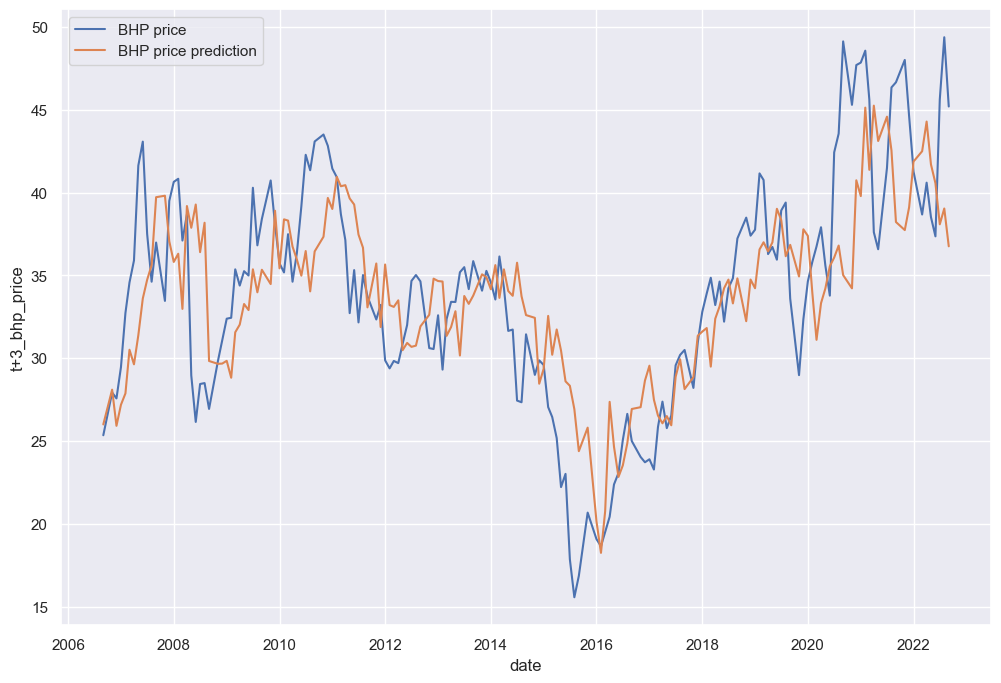

In [74]:
sns.lineplot(x=df_model_pre.index,y=df_model_pre[column_target],label='BHP price')
sns.lineplot(x=df_model_pre.index,y=bhp_model.predict(df_model_pre[columns_train]),label='BHP price prediction')

In [75]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-1_ironore_aud_min_max_scaled','t-2_ironore_aud_min_max_scaled']
column_target = 't+3_bhp_price'
bhp_model = LinearRegression().fit(df_train[columns_train], df_train[column_target])
np.mean(abs(bhp_model.predict(df_test[columns_train])-df_test[column_target]))

5.538309536818698

<Axes: xlabel='date', ylabel='t+3_bhp_price'>

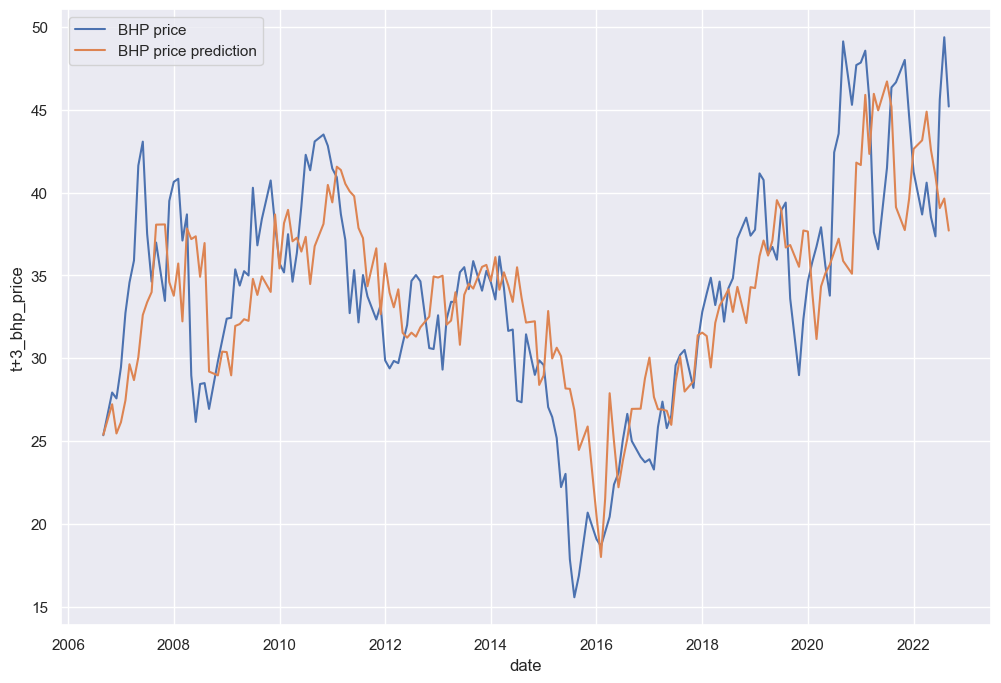

In [76]:
sns.lineplot(x=df_model_pre.index,y=df_model_pre[column_target],label='BHP price')
sns.lineplot(x=df_model_pre.index,y=bhp_model.predict(df_model_pre[columns_train]),label='BHP price prediction')

In [77]:
df_model_pre_future = df_model[columns_train].dropna()

<Axes: xlabel='date'>

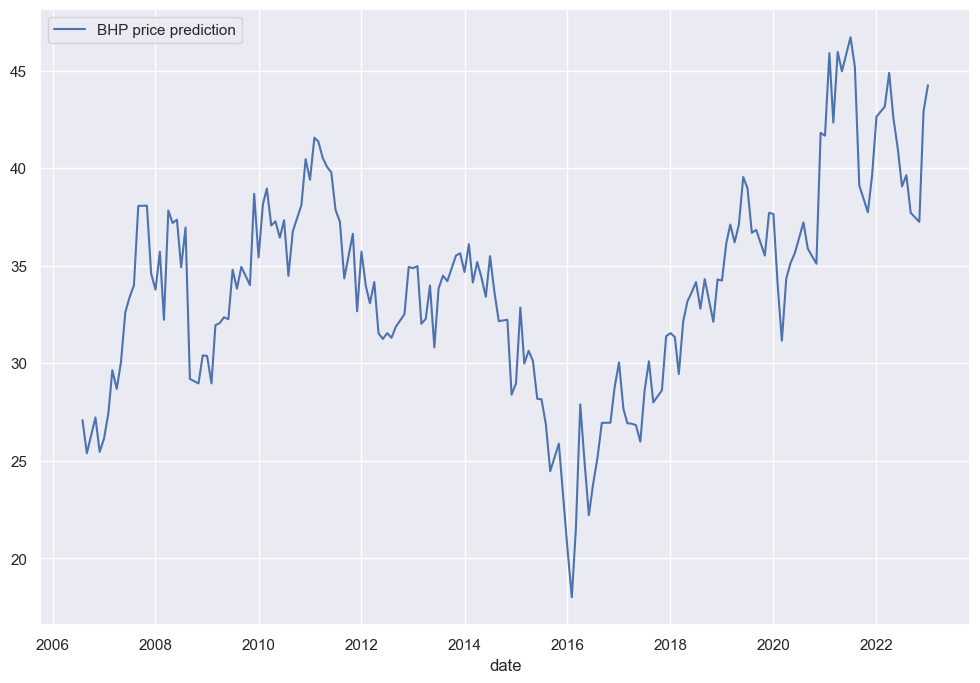

In [78]:
sns.lineplot(x=df_model_pre_future.index,y=bhp_model.predict(df_model_pre_future),label='BHP price prediction')

Great chance for investment now as the price has the tedency to go up in the upcoming 3 months after plunge

In [79]:
from sklearn.tree import DecisionTreeRegressor

In [80]:
columns_train = ['t-1_bhp_price','t-2_bhp_price','t-3_bhp_price','t-1_bhp_pct','t-2_bhp_pct','t-1_ironore_aud_min_max_scaled','t-2_ironore_aud_min_max_scaled']
column_target = 't+3_bhp_price'

In [81]:
for i in range(1,8):
    treemodel = DecisionTreeRegressor(max_depth = i)
    treemodel = treemodel.fit(df_train[columns_train], df_train[column_target])
    print('Tree level:',i," error:",np.mean(abs(treemodel.predict(df_test[columns_train])-df_test[column_target])))

Tree level: 1  error: 8.279444660920761
Tree level: 2  error: 6.0657534317797905
Tree level: 3  error: 5.293551993333768
Tree level: 4  error: 5.96588357974743
Tree level: 5  error: 6.187092260078147
Tree level: 6  error: 5.6891841217323575
Tree level: 7  error: 7.775345837628399


In [82]:
from sklearn import tree

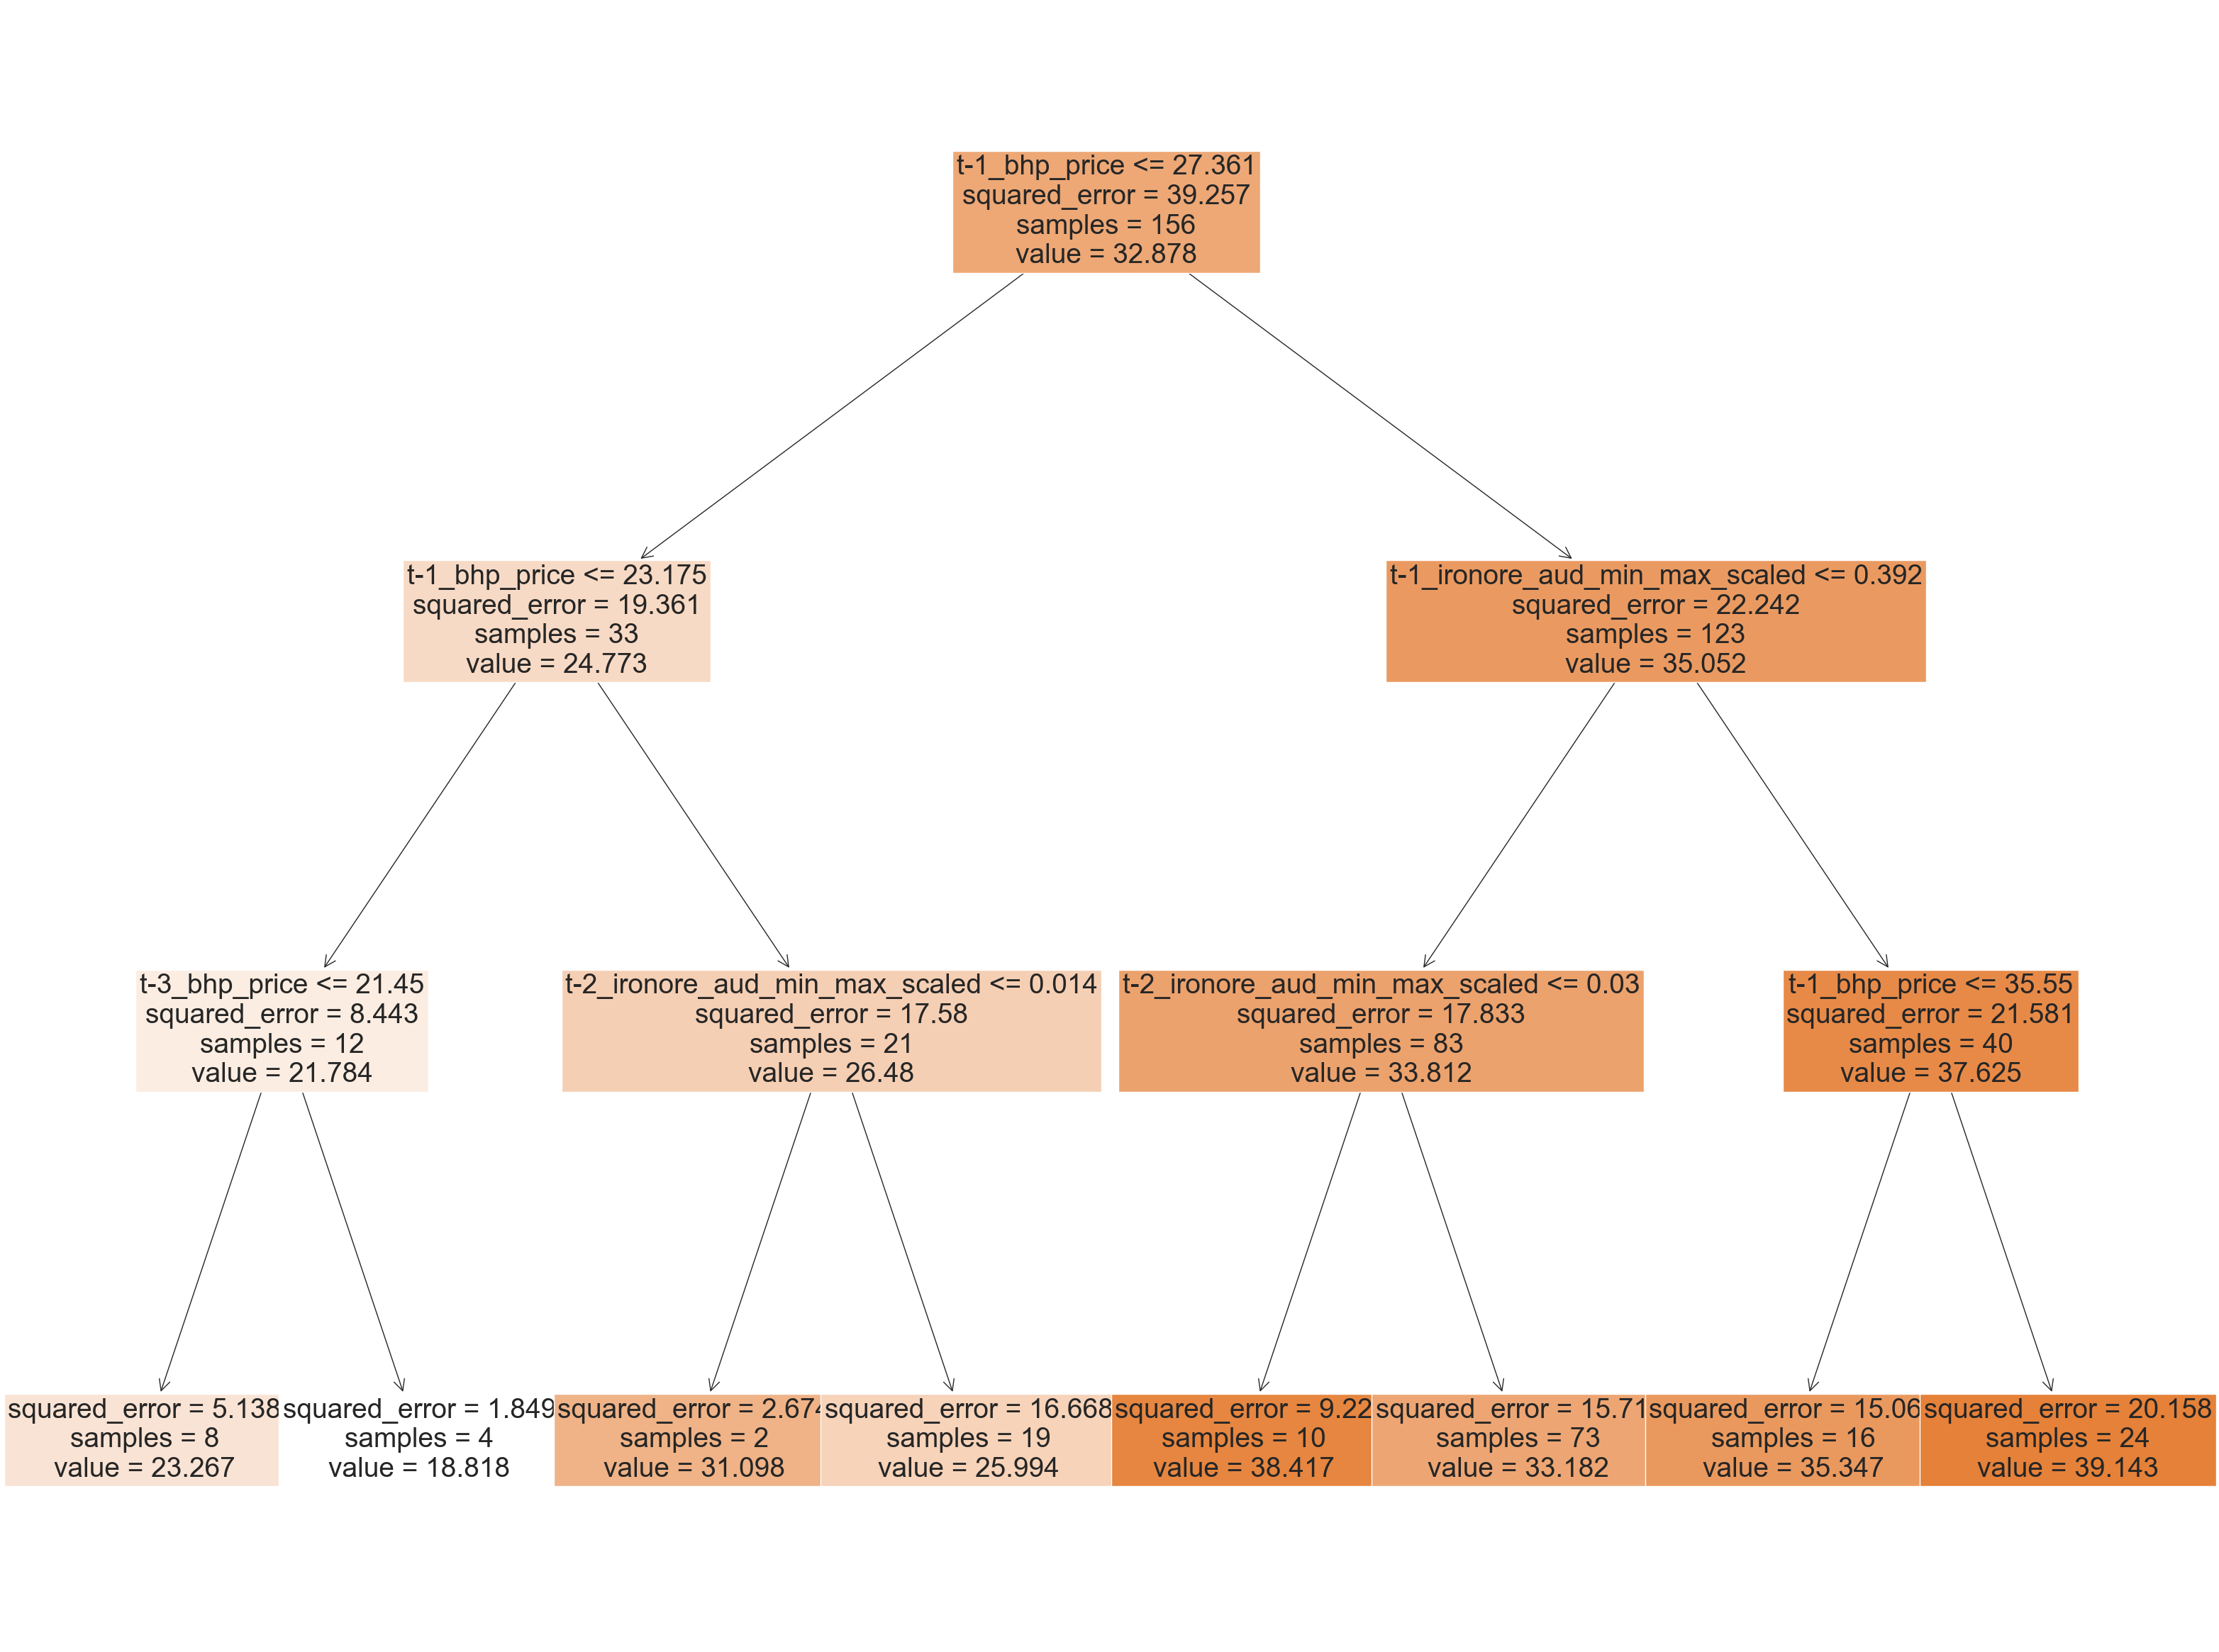

In [83]:
treemodel = DecisionTreeRegressor(max_depth = 3)
treemodel = treemodel.fit(df_train[columns_train], df_train[column_target])
fig = plt.figure(figsize=(40,30))
_ = tree.plot_tree(treemodel, feature_names=columns_train,fontsize=28,filled=True)

<Axes: xlabel='date'>

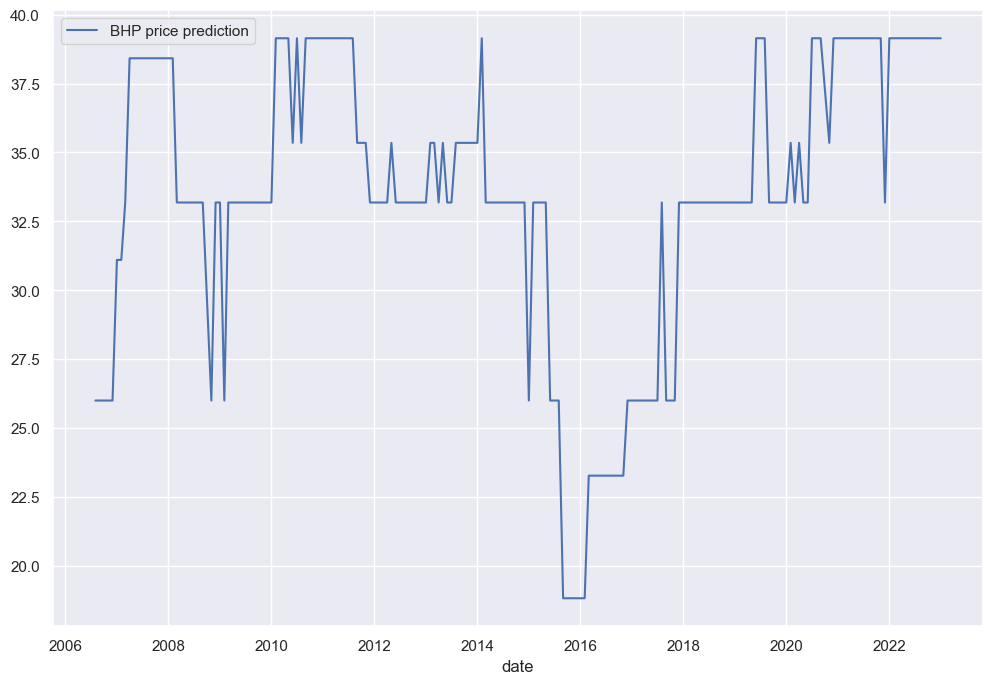

In [84]:
sns.lineplot(x=df_model_pre_future.index,y=treemodel.predict(df_model_pre_future),label='BHP price prediction')